In [1]:
#import relevant packages
from matplotlib import pyplot as plt
import os
import random
from matplotlib.image import imread
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             accuracy_score, 
                             f1_score, 
                             roc_auc_score)
from sklearn.utils import shuffle
from keras.preprocessing.image import (ImageDataGenerator, 
                                       img_to_array, 
                                       array_to_img, 
                                       load_img)

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

from keras.applications import resnet50
from keras.applications.resnet50 import preprocess_input
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping,LearningRateScheduler
from keras.preprocessing.image  import ImageDataGenerator


#silence pandas warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:

#create directories and inspect size of dataset
train_dir = '/Users/sujiaying/Downloads/dogs-vs-cats/train'
test_dir  = '/Users/sujiaying/Downloads/dogs-vs-cats/test1'
print('Number of Training Images: '+ str(len(os.listdir(train_dir))))
print('Number of Test Images: ' + str(len(os.listdir(test_dir))))  


Number of Training Images: 25000
Number of Test Images: 12500


In [12]:
#create filenames and categories
def category(path): 
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

x_train_imgname = filename(train_dir) 
x_test_imgname = filename(test_dir)
y_train_label = category(train_dir)

#create dataframes for train and test data
train_image_df = pd.DataFrame({ 'filename': x_train_imgname, 'category': y_train_label})
test_image_df = pd.DataFrame({'filename': x_test_imgname})

# Data split into train data and validation data
train_valid_df, df_holdout = train_test_split(train_image_df, test_size = 0.04)
df_train, valid_df = train_test_split(train_valid_df, test_size = 0.2)

train_images = df_train.shape[0]
valid_images = valid_df.shape[0]
holdout_images = df_holdout.shape[0]
test_images = test_image_df.shape[0]

#inspect the number of images for each type

print('no. of train images',train_images)
print('no. of validation images',valid_images)
holdout_images
test_images 



no. of train images 19200
no. of validation images 4800


12500

In [4]:
#create a function to extract image ID, category and image paths from directory

def img_path(directory):
    paths = []
    category = []
    ID_no = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        paths.append(path)
        category.append(file.split('.')[0])
        ID_no.append(file.split('.')[1])
    return ID_no, paths, category


#create function to display random images in a grid

def showImages(data,num_row  = 3,num_col =  3, name = 'any', subtitle = 'off'):
    
    # create dataframes for cat and dog pictures
    df_cat,df_dog = data[data['Category'] == 'cat'], data[data['Category'] == 'dog']

    
    if name == 'dog':
        X, Y  = df_dog['img_paths'], df_dog['ID_no']
    elif name == 'cat':
        X, Y  = df_cat['img_paths'], df_cat['ID_no']     
    else:
        X, Y  = data['img_paths'], data['ID_no']     
    #use shuffle() function to generate random set of images
    (X_rand, Y_rand) = shuffle(X, Y)
    
    # plot images using matplotlib 
    
    fig, ax = plt.subplots(num_row,num_col,figsize = (12,12), dpi = 100)
    fig.patch.set_facecolor('#f5f6f6')
    axes = ax.ravel()
    
    for idx,ax  in enumerate(axes):
        x = load_img(X_rand.iloc[idx],target_size= (125, 125))
        ax.imshow(x)
        if subtitle == 'on':
            ax.set_title("{}".format(Y_rand.iloc[idx]))
        else:
            ax.set_title('')
        ax.axis('off')
        plt.subplots_adjust(wspace =0)
    #fig.tight_layout()

    
ID_no, img_paths, train_images = img_path(train_dir)
df_visual = pd.DataFrame({'ID_no':ID_no,'Category':train_images, 'img_paths': img_paths})


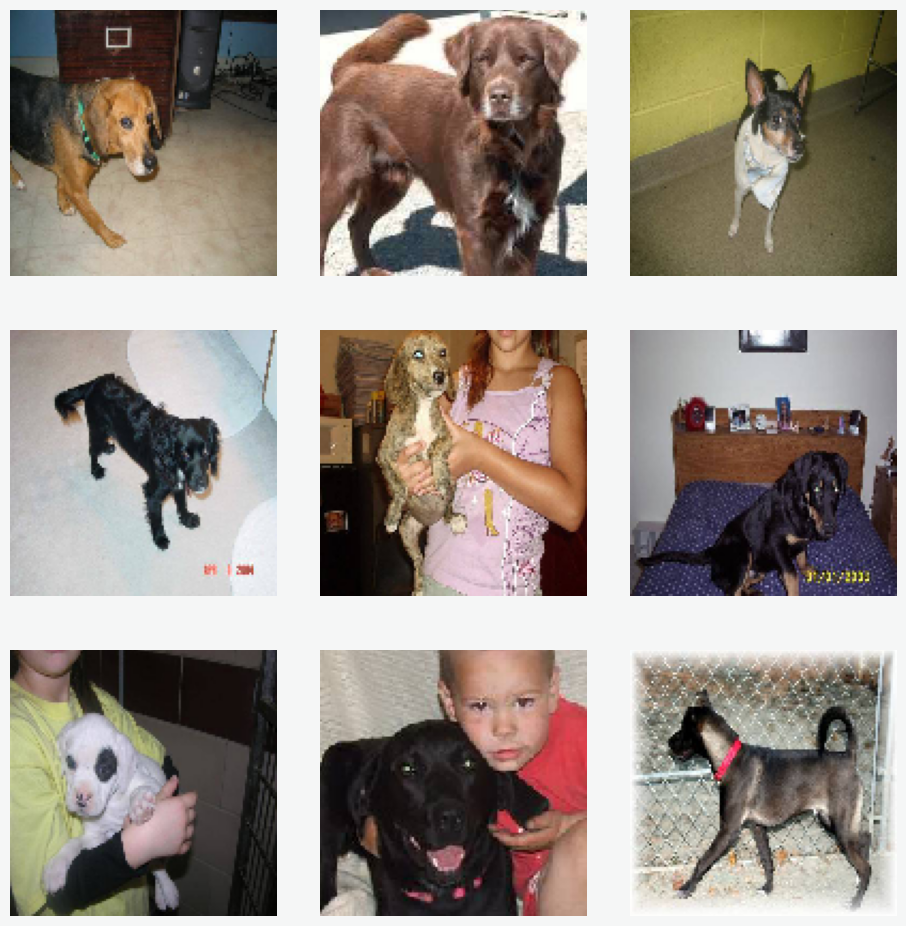

In [5]:
#inspect random sample of dog images in a 3x3 matrix using showImages function 
showImages(df_visual,3,3, name = 'dog')

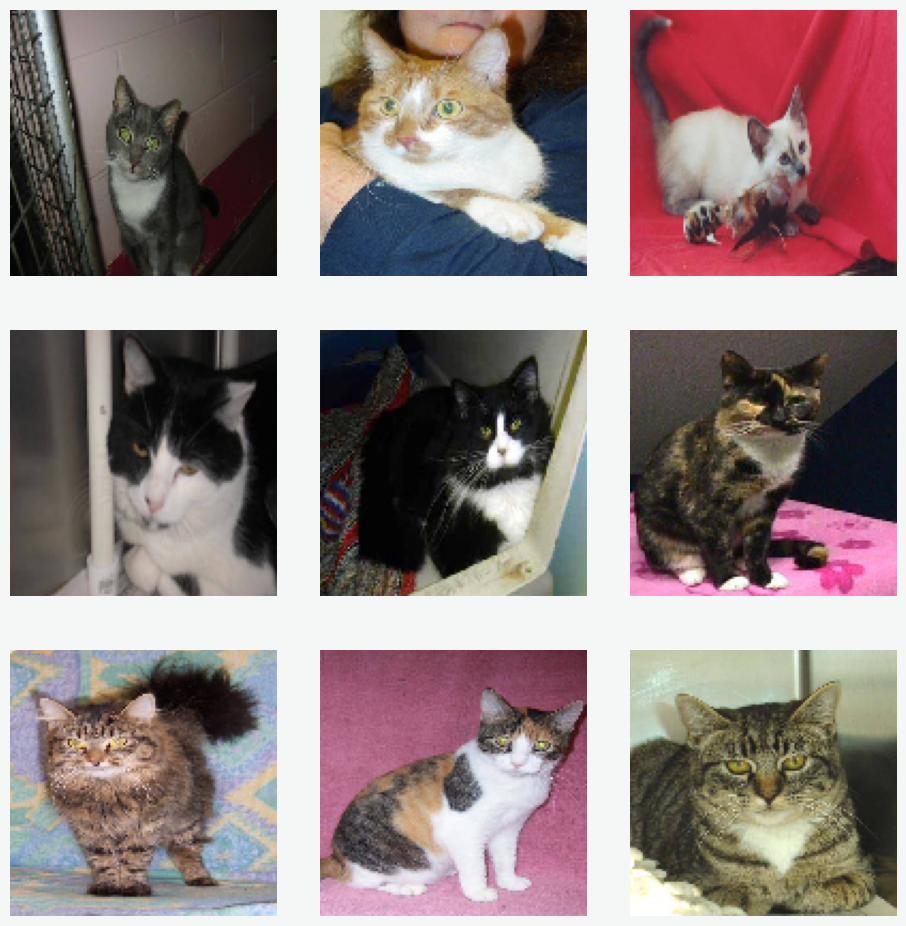

In [5]:
#inspect random sample of cat images in a 3x3 matrix using showImages function 
showImages(df_visual,3,3, name = 'cat')

In [6]:
#data pre-processing
#before we start training the model, we will do image augmentation to increase the number of images in our dataset
#define a function to add random noise to image, which helps prevents overfitting

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

#define a function for image augmentation which will plot the augmented images 

img_size = 224
batch_size = 128


def data_argumentation_show(n, grid_size):
  
    image_generator= ImageDataGenerator(
            zoom_range = 0.1,
            rotation_range = 25,
            horizontal_flip = True,
            height_shift_range =0.2,
            width_shift_range = 0.2,
            fill_mode='nearest',
            rescale = 1/255,
            preprocessing_function= add_noise)

    
    sample_data = image_generator.flow_from_dataframe(
            (df_train.sample(n)),
            train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            class_mode = 'categorical')
  
  #subplot grid 
    fig = plt.figure(figsize = (10,10))
    fig.patch.set_facecolor('#f5f6f6')
    for i in range(0,grid_size*grid_size):
        plt.subplot(grid_size,grid_size, i+1)
        for x,y in sample_data:
            img = x[0]
            plt.imshow(img)
            plt.axis('off')
            break
            plt.tight_layout()
    #fig.show()

     
    
    return None



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 1 validated image filenames belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

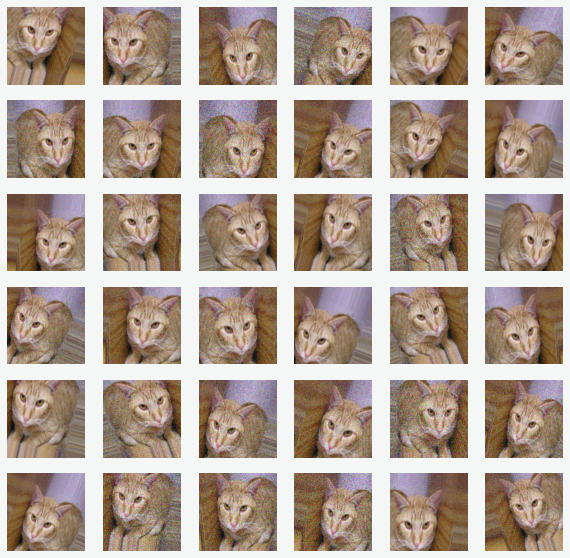

In [7]:
#inspect a random sample of augmented images
data_argumentation_show(1, 6)

In [8]:
train_aug_map = ImageDataGenerator(
            zoom_range = 0.1,
            rotation_range = 25,
            horizontal_flip = True,
            height_shift_range =0.2,
            width_shift_range = 0.2,
            fill_mode='nearest',
            preprocessing_function = preprocess_input)

res_train_data = train_aug_map.flow_from_dataframe(
            df_train, train_dir,
            x_col = 'filename',
            y_col = 'category',
            target_size = (img_size, img_size),
            batch_size = batch_size,
            class_mode = 'categorical')


valid_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_valid_data = valid_aug_map.flow_from_dataframe(
             valid_df, train_dir,
             x_col = 'filename',
             y_col = 'category',
             target_size = (img_size, img_size),
             batch_size = batch_size,
             class_mode = 'categorical')


#holdout data rescaling images

holdout_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_holdout_data = holdout_aug_map.flow_from_dataframe(
             df_holdout, train_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)

Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


# Model training
-Use transfer learning on the ResNet50 model 

In [9]:
#load ResNet
resNet = tf.keras.applications.ResNet50(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224,224, 3))

# Freeze layers to reduce training time
resNet.trainable = False 
resNet_model = Sequential([
        resNet,
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dropout(0.4),
        Dense(2, activation = 'softmax')])
     

optimizer = optimizers.Adam(1e-5)


In [10]:
epoch = 50
learning_rate = 3e-5 
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5 
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

epochs = 20
epochs_range = [i for i in range(50 if epochs<50 else epochs)]
learn_rate = [lrfn(x) for x in epochs_range]
earlystop = EarlyStopping(patience= 5)
    
lr_callback = LearningRateScheduler(lrfn, verbose = True)

callbacks = [earlystop, lr_callback]



In [13]:
#train and validate training data 

resNet_model.compile(optimizer = optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

#running two epochs here for illustrative purposes only, in the interest of time. 
#recommended number would be around 15.
resnet_history = resNet_model.fit(res_train_data, epochs = 2,
                          validation_data = res_valid_data,
                          validation_steps= valid_images//batch_size,
                          steps_per_epoch= train_images//batch_size,
                          callbacks = callbacks)

Epoch 1/2

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
150/150 [==============================] - 7650s 51s/step - loss: 2.3831 - accuracy: 0.4815 - val_loss: 1.5650 - val_accuracy: 0.5049
Epoch 2/2

Epoch 00002: LearningRateScheduler reducing learning rate to 3e-05.
150/150 [==============================] - 1114s 7s/step - loss: 1.4388 - accuracy: 0.8745 - val_loss: 0.0565 - val_accuracy: 0.9848


In [18]:
#test hold-out data

res_pred = resNet_model.predict_generator(res_holdout_data)
df_holdout['res_pred'] = np.argmax(res_pred, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())

df_holdout['res_pred'] = df_holdout['res_pred'].map(labels)


In [19]:
#create function to plot confusion matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    # to generate the text in each quadrant
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('#f5f6f6')
    sns.heatmap(cf,annot=box_labels,fmt="",linewidths = 1,square = True,linecolor= '#f5f6f6',
                cmap=cmap,cbar=cbar,annot_kws={'fontfamily':'serif','size':18,'weight':'bold'},
                xticklabels=categories,
                yticklabels=categories,)

    if xyplotlabels:
        plt.ylabel('True label', **{'fontfamily':'serif','size':12,'weight':'bold'})
        plt.xlabel('Predicted label' + stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    else:
        plt.xlabel(stats_text,**{'fontfamily':'serif','size':12,'weight':'bold'})
    
    plt.gca().set_xticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})
    plt.gca().set_yticklabels(categories, {'fontfamily':'serif','size':16,'weight':'bold'})

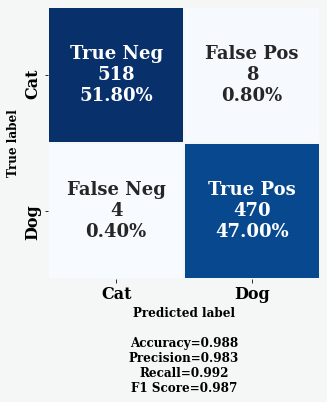

In [21]:
#plot confusion matrix to compare accuracy, precision and recall for cat and dog images

res_cf_matrix = confusion_matrix(df_holdout['category'],df_holdout['res_pred'])

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(res_cf_matrix,figsize = (10,5),
                      group_names=labels,cbar = False,
                      categories=categories, 
                      title = 'Hold-out data confusion matrix')

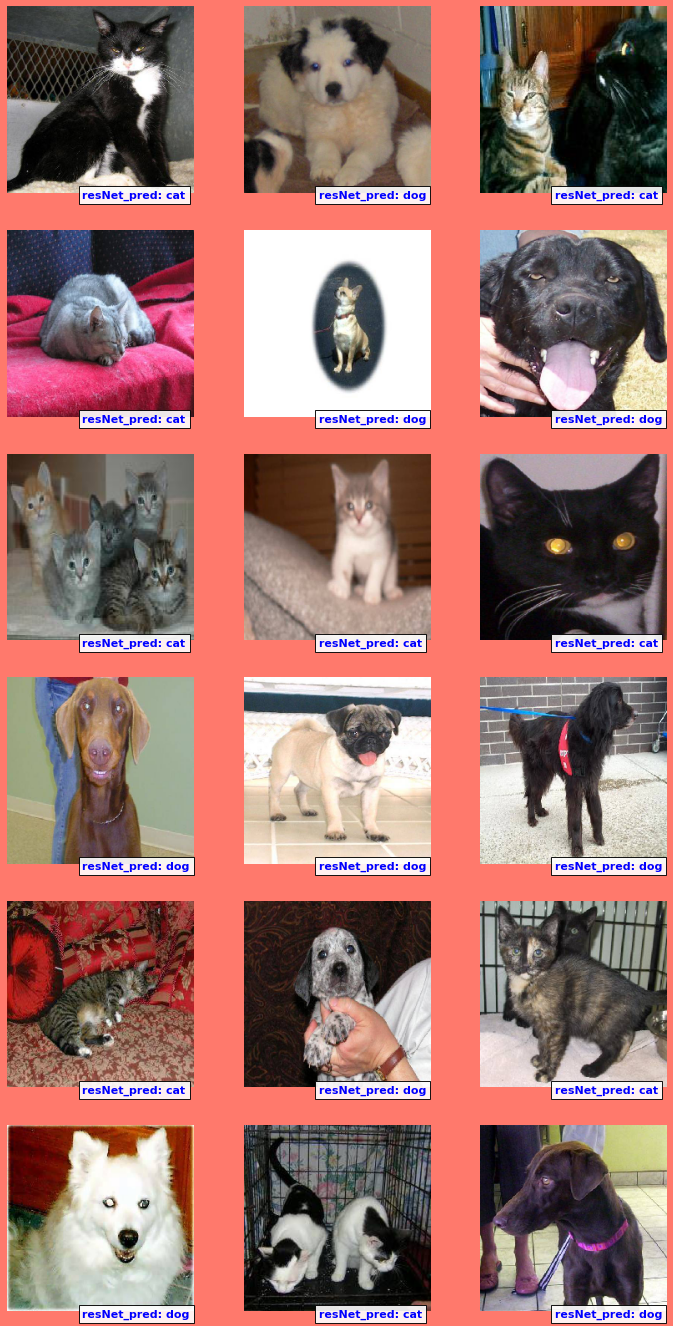

In [22]:
#visualize a sample of the predictions made on the hold-out data

pred_sample = df_holdout.sample(18)
pred_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('xkcd:salmon')

for index, row in pred_sample.iterrows():
    filename = row['filename']
    res_pred = row['res_pred']
    img = load_img( train_dir + '/'+ filename, target_size= (img_size, img_size))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(90, 230, 'resNet_pred: {}'.format(res_pred), color='blue',fontsize= 11, weight='bold', bbox=dict(facecolor='white', alpha=0.9))
   
fig.show()
   

In [23]:
#run model on test data 

#data augmentation on test data
test_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)

res_test_data = test_aug_map.flow_from_dataframe(
             test_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)


res_pred_test = resNet_model.predict_generator(res_test_data)
test_image_df['res_pred_test'] = np.argmax(res_pred_test, axis = -1)
labels = dict((v,k) for k,v in res_train_data.class_indices.items())

test_image_df['res_pred_test'] = test_image_df['res_pred_test'].map(labels)

Found 12500 validated image filenames.


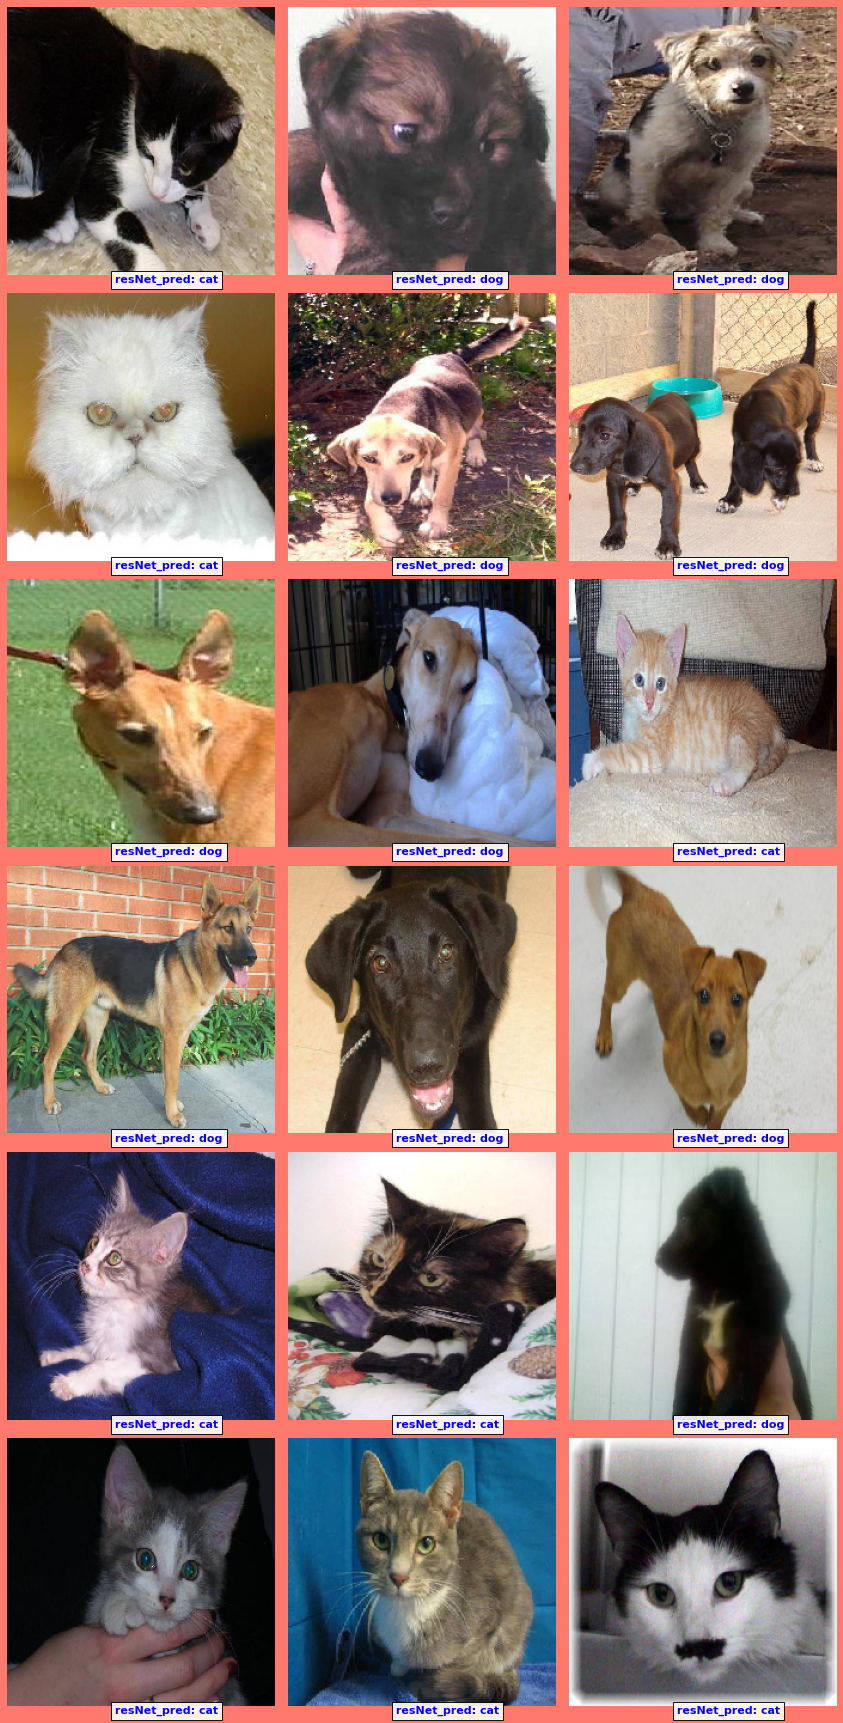

In [24]:
#visualize a sample of the predictions made on the hold-out data

pred_sample = df_holdout.sample(18)
pred_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('xkcd:salmon')

for index, row in pred_sample.iterrows():
    filename = row['filename']
    res_pred = row['res_pred']
    img = load_img( train_dir + '/'+ filename, target_size= (img_size, img_size))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(90, 230, 'resNet_pred: {}'.format(res_pred), color='blue',fontsize= 11, weight='bold',bbox=dict(facecolor='white', alpha=0.9))
   
plt.tight_layout()
fig.show()
   

In [31]:
#create a new column in df_holdout for labels 
# create a list of our conditions
conditions = [
    (df_holdout['category'] == 'dog') & (df_holdout['res_pred'] == 'dog'),
    (df_holdout['category'] == 'cat') & (df_holdout['res_pred'] == 'cat'),
    (df_holdout['category'] == 'cat') & (df_holdout['res_pred'] == 'dog'),
    (df_holdout['category'] == 'dog') & (df_holdout['res_pred'] == 'cat'),
    ]

# create a list of the values we want to assign for each condition
values = ['True pos', 'True neg', 'False pos', 'False neg']

# create a new column and use np.select to assign values to it using our lists as arguments
df_holdout['label'] = np.select(conditions, values)

# inspect updated DataFrame
df_holdout.head()

filename category res_pred     label
10589  cat.11798.jpg      cat      cat  True neg
1323     dog.210.jpg      dog      dog  True pos
9482    dog.4128.jpg      dog      dog  True pos
20374   dog.5517.jpg      dog      dog  True pos
4929    cat.6989.jpg      cat      cat  True neg

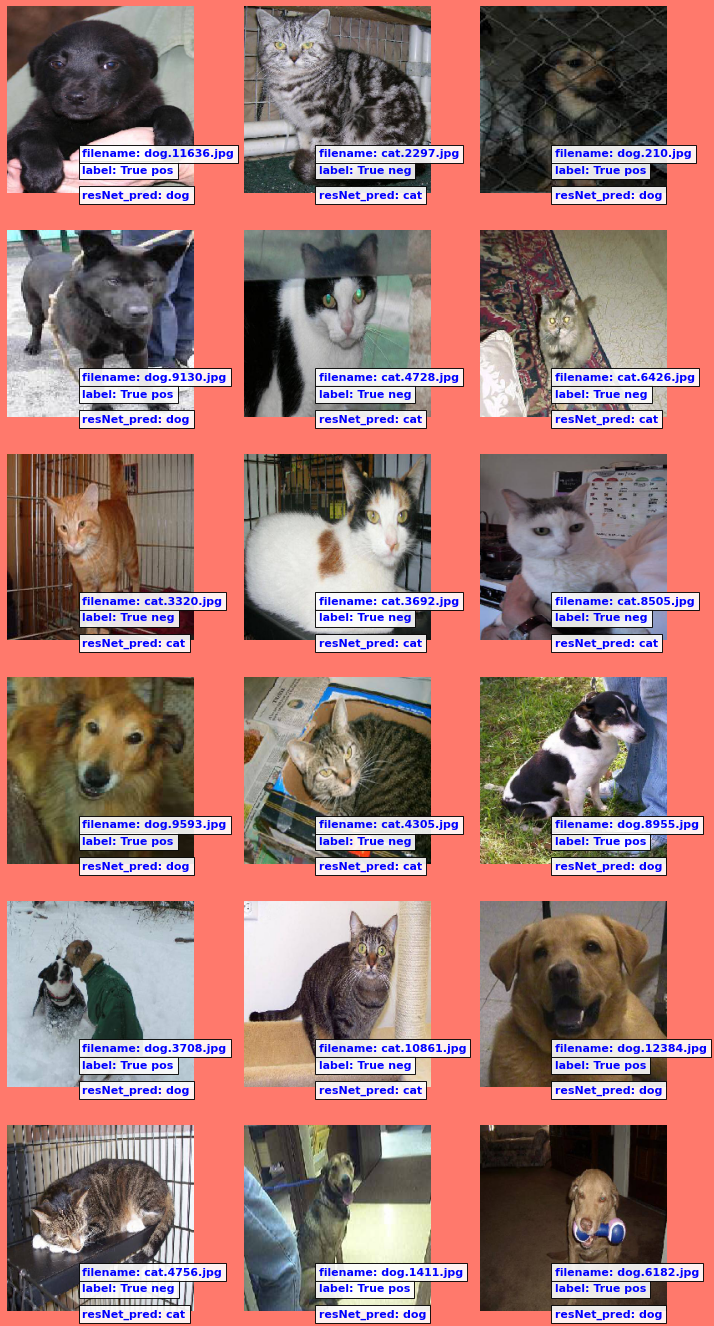

In [40]:

label_sample = df_holdout.sample(18)
label_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('xkcd:salmon')

for index, row in label_sample.iterrows():
    filename = row['filename']
    res_pred = row['res_pred']
    label = row['label']
    img = load_img( train_dir + '/'+ filename, target_size= (img_size, img_size))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(90, 200,'label: {}'.format(label), color='blue',fontsize= 11, weight='bold',bbox=dict(facecolor='white', alpha=0.9))
    plt.text(90, 230,'resNet_pred: {}'.format(res_pred), color='blue',fontsize= 11, weight='bold',bbox=dict(facecolor='white', alpha=0.9))
    plt.text(90, 180,'filename: {}'.format(filename), color='blue',fontsize= 11, weight='bold',bbox=dict(facecolor='white', alpha=0.9))
fig.show()



In [55]:
#let's look at samples of images the model did poorly in (e.g. false pos)

#first, create a new dataframe for false pos images
df_holdout_gp=df_holdout.groupby('label')
df_holdout_falsepos=a.get_group('False pos')

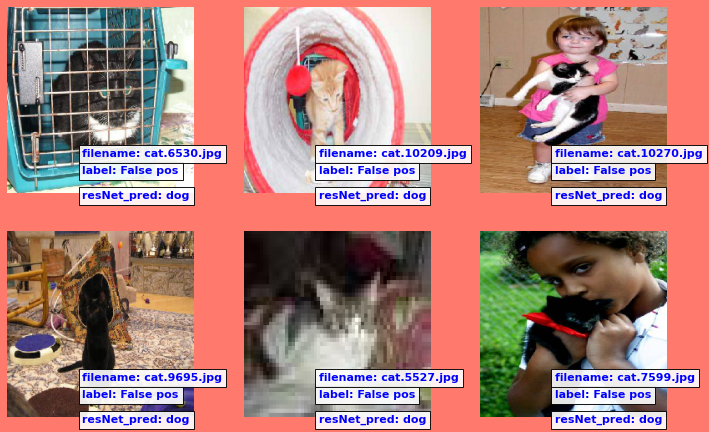

In [56]:
#plot the false pos images 

label_sample = df_holdout_falsepos.sample(6)
label_sample.reset_index(drop = True, inplace = True)

fig = plt.figure(figsize=(12,24))
fig.patch.set_facecolor('xkcd:salmon')

for index, row in label_sample.iterrows():
    filename = row['filename']
    res_pred = row['res_pred']
    label = row['label']
    img = load_img( train_dir + '/'+ filename, target_size= (img_size, img_size))
    plt.subplot(6,3, index+1)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.text(90, 200,'label: {}'.format(label), color='blue',fontsize= 11, weight='bold',bbox=dict(facecolor='white', alpha=0.9))
    plt.text(90, 230,'resNet_pred: {}'.format(res_pred), color='blue',fontsize= 11, weight='bold',bbox=dict(facecolor='white', alpha=0.9))
    plt.text(90, 180,'filename: {}'.format(filename), color='blue',fontsize= 11, weight='bold',bbox=dict(facecolor='white', alpha=0.9))
fig.show()

#we can see that the cat images the model wrongly classified as dog are generally hard to make out e.g.face is obstructed